In [289]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision.utils import save_image
import seaborn as sns
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# VAE

### Encoder

In [290]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Encoder, self).__init__()
        self.lin1 = nn.Linear(x_dim, h_dim1)
        self.lin2 = nn.Linear(h_dim1, h_dim2)
        self.lin31 = nn.Linear(h_dim2, z_dim) # mu
        self.lin32 = nn.Linear(h_dim2, z_dim) # log_var
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin31(x), self.lin32(x) # mu, log_var

### Decoder

In [291]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Decoder, self).__init__()
        self.lin4 = nn.Linear(z_dim, h_dim2)
        self.lin5 = nn.Linear(h_dim2, h_dim1)
        self.lin6 = nn.Linear(h_dim1, x_dim)
        
    def log_prob(self, x, p):
        distribution = torch.distributions.continuous_bernoulli.ContinuousBernoulli(probs=p)
        #print(torch.sum(distribution.log_prob(torch.round(x))))
        return -torch.sum(distribution.log_prob(x))

    def forward(self, z):
        h = F.relu(self.lin4(z))
        h = F.relu(self.lin5(h))
        return torch.sigmoid(self.lin6(h)) 

### Model

In [292]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)
        
    def sampling(self, mu, log_var): 
        std = torch.sqrt(torch.exp(log_var))
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        mu_d = self.decoder(z)
        return mu_d, mu, log_var
    
    def kl_div(self, mu, sigma):
        N = mu.shape[1]
        mu = mu.reshape(mu.shape[0], mu.shape[1], 1)
        tr_term   = torch.sum(sigma, axis = 1)
        det_term  = -torch.log(torch.prod(sigma, axis = 1))
        quad_term = torch.transpose(mu, 1, 2) @ mu
        return torch.sum(0.5 * (tr_term + det_term + quad_term - N))
    
    def loss_function(self, data, beta):
        p, mu, log_var = self.forward(data)
        kl_loss = self.kl_div(mu, torch.exp(log_var))
        recon_loss = self.decoder.log_prob(torch.round(data), p)
        return recon_loss + beta * kl_loss
    
    def generate(self, z):
        return self.decoder(z)

# Loss

In [293]:
def kl_mvn(mu, sigma, device):
    N = mu.shape[1]
    mu = mu.reshape(mu.shape[0], mu.shape[1], 1)
    tr_term   = torch.sum(sigma, axis = 1)
    det_term  = -torch.log(torch.prod(sigma, axis = 1))
    quad_term = torch.transpose(mu, 1, 2) @ mu
    return torch.sum(0.5 * (tr_term + det_term + quad_term - N))

In [294]:
def loss_function(vae, p, x, mu, log_var, beta):
    BCE = vae.decoder.log_prob(torch.round(x), p)
    KLD = kl_mvn(mu, torch.exp(log_var), device)
    return BCE + beta * KLD

# Train and test functions

In [295]:
def test(vae, test_loader, beta):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.reshape([-1, 784])
            test_loss += vae.loss_function(data, beta).item()
        
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss}')
    return test_loss

In [296]:
def train(vae, epoch, optimizer, train_loader, beta):
    vae.train()
    train_loss = 0
    batch_idx = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        data = data.reshape([-1, 784])
        optimizer.zero_grad()
        loss = vae.loss_function(data, beta)
        #print(vae.decoder.log_prob(torch.round(data), recon_batch))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        batch_idx += 1
    train_loss /= len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {train_loss}')
    return train_loss

# Train and test sets

In [297]:
# Batch size
bs = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Training

In [298]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters())

train_losses = []
test_losses = []
for epoch in range(1, 51):
    train_loss = train(vae, epoch, optimizer, train_loader, 1)
    train_losses.append(train_loss)
    vae = vae.cpu() # weird stuff happens when model is on GPU during testing #macissues
    test_loss = test(vae, test_loader, 1)
    test_losses.append(test_loss)
    vae = vae.to(device) # back to GPU

====> Epoch: 1 Average loss: -1371.5497054365158
====> Test set loss: -1411.6968400390624
====> Epoch: 2 Average loss: -1419.8277007161457
====> Test set loss: -1428.7349265625
====> Epoch: 3 Average loss: -1430.5360788411458
====> Test set loss: -1434.7833662109374
====> Epoch: 4 Average loss: -1436.3195591145834
====> Test set loss: -1438.6384896484376
====> Epoch: 5 Average loss: -1441.1586161458333
====> Test set loss: -1442.2710203125
====> Epoch: 6 Average loss: -1444.5751537109375
====> Test set loss: -1447.9855916015624
====> Epoch: 7 Average loss: -1447.7070530598958
====> Test set loss: -1449.398477734375
====> Epoch: 8 Average loss: -1449.8596869791666
====> Test set loss: -1450.7397412109376
====> Epoch: 9 Average loss: -1452.342825455729
====> Test set loss: -1451.0277017578126
====> Epoch: 10 Average loss: -1453.931423046875
====> Test set loss: -1454.442444921875
====> Epoch: 11 Average loss: -1455.4639106770833
====> Test set loss: -1455.694882421875
====> Epoch: 12 Ave

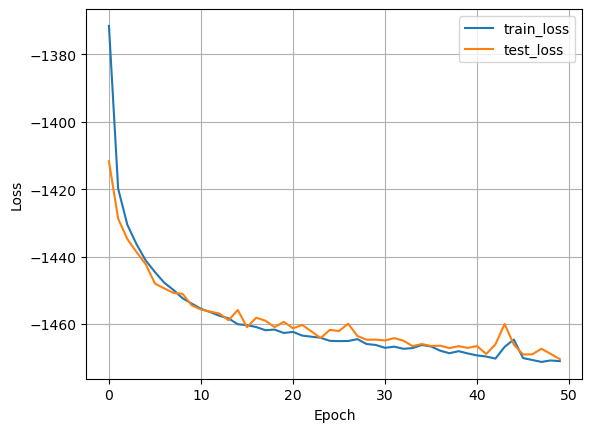

In [300]:
sns.lineplot(data=train_losses, label = 'train_loss')
sns.lineplot(data=test_losses, label = 'test_loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [301]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    sample = vae.generate(z).cpu()
    save_image(sample.view(64, 1, 28, 28), './samples/sample' + '.png')